In [1]:
## all code derived from https://www.tensorflow.org/tutorials/structured_data/time_series

In [34]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 15)
mpl.rcParams['axes.grid'] = False

In [35]:
df_avg = pd.read_csv('data/new_avg.csv')
date_time = pd.to_datetime(df_avg.pop('date'), format='%Y-%m-%d')

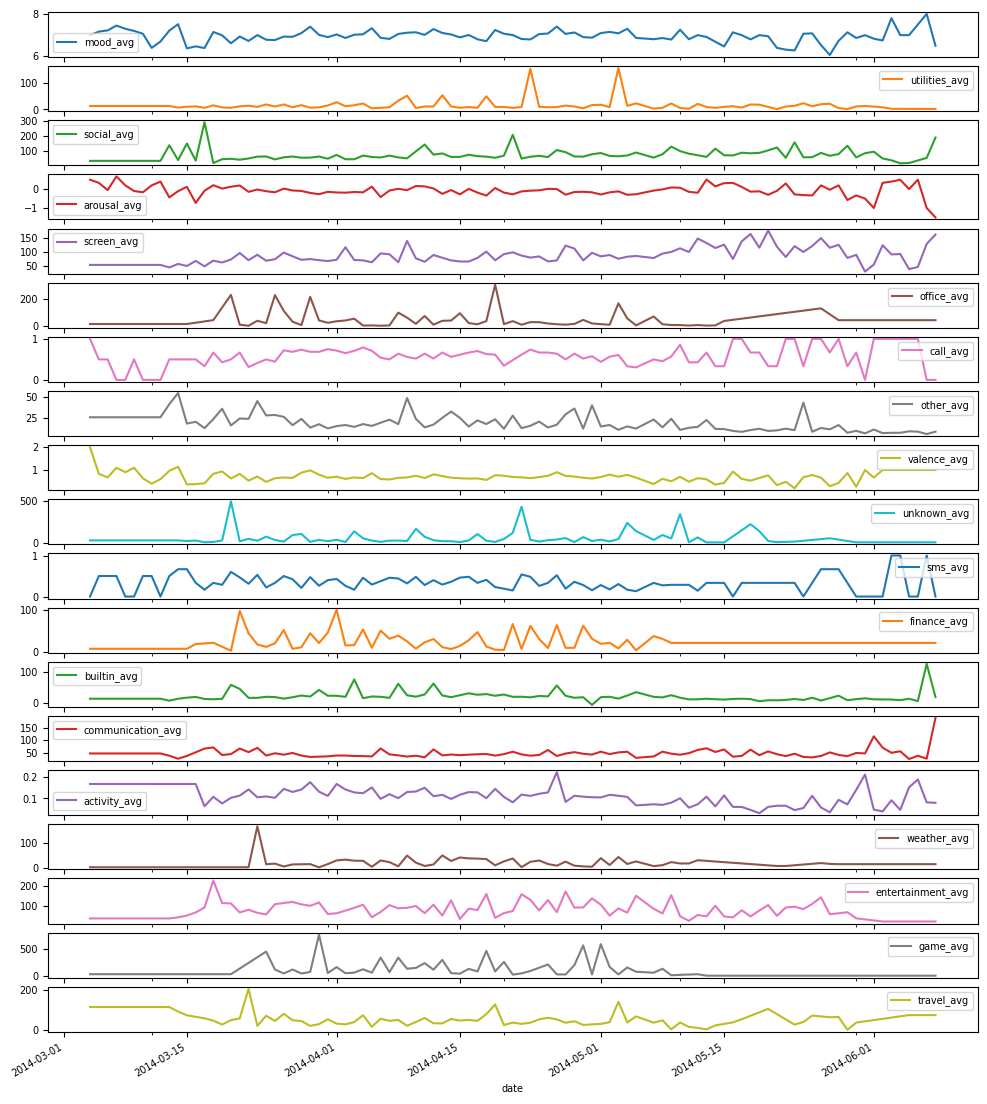

In [36]:
plot_cols = ['mood_avg',
 'utilities_avg',
 'social_avg',
 'arousal_avg',
 'screen_avg',
 'office_avg',
 'call_avg',
 'other_avg',
 'valence_avg',
 'unknown_avg',
 'sms_avg',
 'finance_avg',
 'builtin_avg',
 'communication_avg',
 'activity_avg',
 'weather_avg',
 'entertainment_avg',
 'game_avg',
 'travel_avg']

plot_features = df_avg[plot_cols]
plot_features.index = date_time

mpl.rcParams["font.size"] = 7
_ = plot_features.plot(subplots=True)


# plot_features = df_avg[plot_cols][:480]
# plot_features.index = date_time[:480]
# _ = plot_features.plot(subplots=True)

In [37]:
## data splitting

column_indices = {name: i for i, name in enumerate(df_avg.columns)}

n = len(df_avg)
train_df = df_avg[0:int(n*0.7)]
val_df = df_avg[int(n*0.7):int(n*0.9)]
test_df = df_avg[int(n*0.9):]

num_features = df_avg.shape[1]

In [38]:
## nornmalisation

# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

# df_std = (df_avg - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')

# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df_avg.keys(), rotation=90)


In [39]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [40]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  # (batch, width, n of features)
  inputs.set_shape([1, self.input_width, 19])
  labels.set_shape([1, self.label_width, 1])

  return inputs, labels

WindowGenerator.split_window = split_window

In [41]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [42]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [43]:
def plot(self, model=None, plot_col='mood_avg', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('number of days')

WindowGenerator.plot = plot

In [44]:
## gaan we ook baseline modellen maken voor alles??

In [45]:
window = WindowGenerator(input_width=6, label_width=6, shift=1,
                     label_columns=['mood_avg'])
window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['mood_avg']

In [46]:
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


val_performance = {}
performance = {}

In [47]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)

Input shape: (1, 6, 19)
Output shape: (1, 6, 1)


In [49]:
history = compile_and_fit(lstm_model, window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1185 - mean_absolute_error: 0.2976 


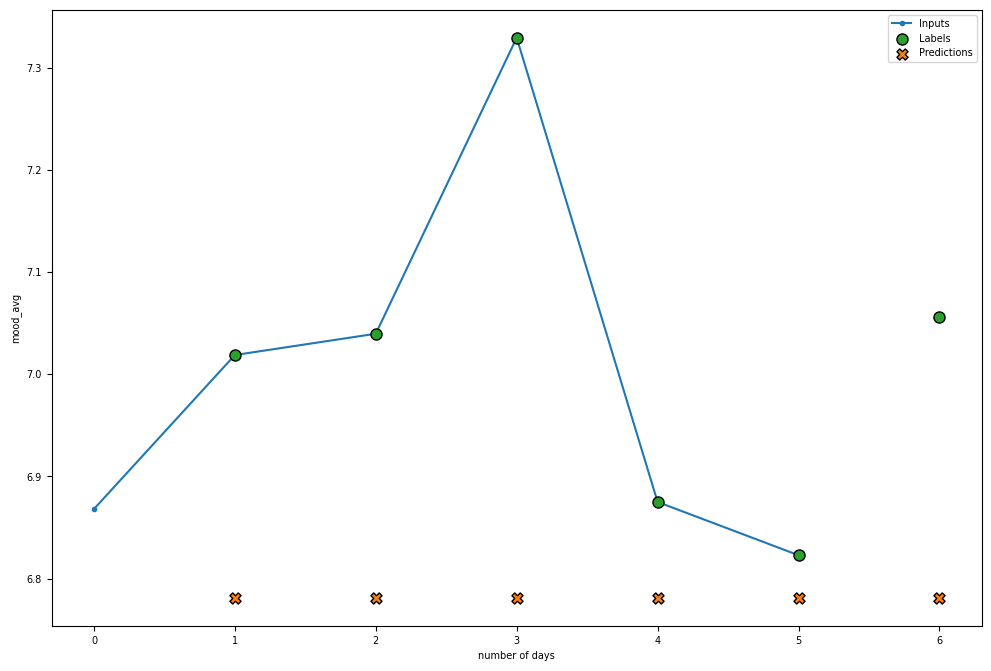

In [50]:
window.plot(lstm_model)

In [19]:
## only 1 predictopn

In [20]:
window = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['mood_avg'])
window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['mood_avg']

In [21]:
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


val_performance = {}
performance = {}

In [22]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [23]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)

Input shape: (1, 6, 19)
Output shape: (1, 1)


In [24]:
def plot(self, model=None, plot_col='mood_avg', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('number of days')

WindowGenerator.plot = plot

In [25]:
history = compile_and_fit(lstm_model, window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.1589 - mean_absolute_error: 6.5595 


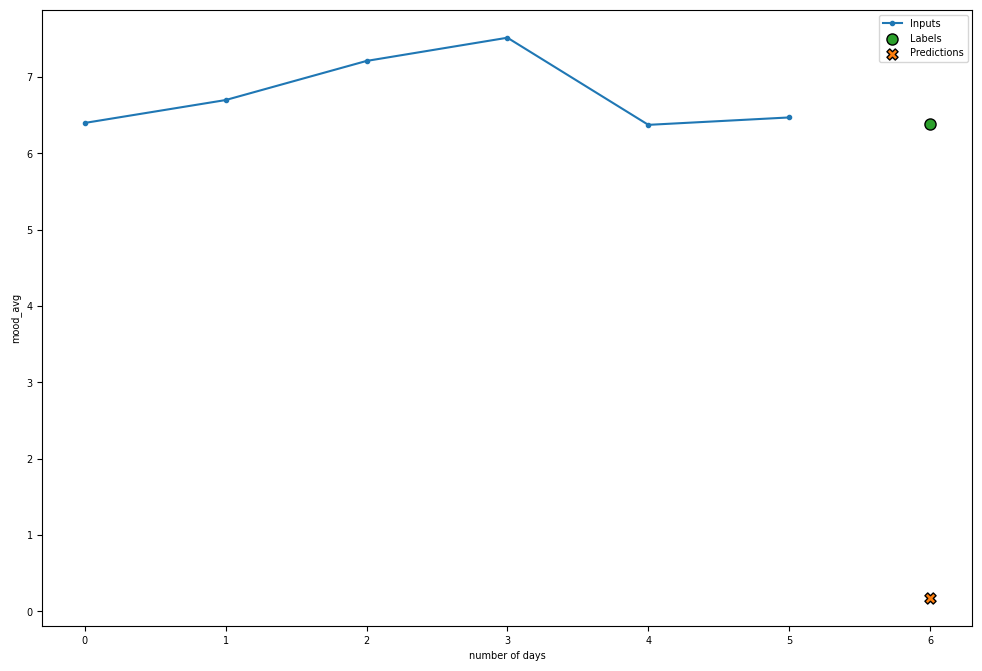

In [26]:
window.plot(lstm_model)

In [27]:
# window = WindowGenerator(input_width=1, label_width=1, shift=1,
#                      label_columns=['mood_avg'])
# window

In [28]:
# MAX_EPOCHS = 1000

# def compile_and_fit(model, window, patience=2):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

#   model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
#   return history


# val_performance = {}
# performance = {}

In [29]:
# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.LSTM(1, return_sequences=True),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

In [30]:
# print('Input shape:', window.example[0].shape)
# print('Output shape:', lstm_model(window.example[0]).shape)

In [31]:
# def plot(self, model=None, plot_col='mood_avg', max_subplots=3):
#   inputs, labels = self.example
#   plt.figure(figsize=(12, 8))
#   plot_col_index = self.column_indices[plot_col]
#   max_n = min(max_subplots, len(inputs))
#   for n in range(max_n):
#     plt.subplot(max_n, 1, n+1)
#     plt.ylabel(f'{plot_col}')
#     plt.plot(self.input_indices, inputs[n, :, plot_col_index],
#              label='Inputs', marker='.', zorder=-10)

#     if self.label_columns:
#       label_col_index = self.label_columns_indices.get(plot_col, None)
#     else:
#       label_col_index = plot_col_index

#     if label_col_index is None:
#       continue

#     plt.scatter(self.label_indices, labels[n, :, label_col_index],
#                 edgecolors='k', label='Labels', c='#2ca02c', s=64)
#     if model is not None:
#       predictions = model(inputs)
#       plt.scatter(self.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Predictions',
#                   c='#ff7f0e', s=64)

#     if n == 0:
#       plt.legend()

#   plt.xlabel('number of days')

# WindowGenerator.plot = plot

In [32]:
# history = compile_and_fit(lstm_model, window)

# IPython.display.clear_output()
# val_performance['LSTM'] = lstm_model.evaluate(window.val, return_dict=True)
# performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0, return_dict=True)

In [33]:
# window.plot(lstm_model)